<a href="https://colab.research.google.com/github/pravin-raut/MachineLearning/blob/Master/dissertation/Currency_%26_Oil_Forecast_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima
!pip install quandl
!pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime,timedelta
import json
import quandl

In [ ]:
import urllib.request

file_path = "https://raw.githubusercontent.com/pravin-raut/MachineLearning/Master/dissertation/Config/Config_Git.json"

# Open the file for reading and load the data from it
with urllib.request.urlopen(file_path) as infile:
  data = json.load(infile)
# Set up API key
  api_key=data["nasdaq"]["api_key"]
quandl.ApiConfig.api_key = api_key


In [ ]:
CurrentDate = (datetime.today() - timedelta(days=0)).strftime('%Y-%m-%d')
CurrentDate
FirstDay='2019-01-01'


In [ ]:

def getDataFromAPI(API,symbol,start_date,end_date):

  if API=="YFinance":
    # Create a ticker object
    ticker = yf.Ticker(symbol)
    # Download historical data
    data = ticker.history(period="1d", start=start_date, end=end_date)

  if API=="Nasdaq":
    data = quandl.get(symbol,start_date=start_date,end_date=end_date)


  return data

In [ ]:

OilPriceInUSD=getDataFromAPI("Nasdaq","OPEC/ORB",FirstDay,CurrentDate).reset_index()
OilPriceInUSD['Date'] = pd.to_datetime(OilPriceInUSD['Date']).dt.date
OilPriceInUSD.set_index('Date', inplace=True)
OilPriceInUSD

OilPriceInUSD=OilPriceInUSD.asfreq('b')
OilPriceInUSD['Original_Oil_Price']=OilPriceInUSD.Value.fillna(method='bfill')
df_Oil_InUSD=OilPriceInUSD[['Original_Oil_Price']]
df_Oil_InUSD

,Original_Oil_Price
Date,
2019-01-02,52.14
2019-01-03,52.93
2019-01-04,55.13
2019-01-07,56.42
2019-01-08,56.09
...,...
2023-06-30,76.14
2023-07-03,76.12
2023-07-04,76.18


In [ ]:
df_USD_EUR=getDataFromAPI("YFinance","EURUSD=X",FirstDay,CurrentDate).reset_index()
df_USD_EUR['Date'] = pd.to_datetime(df_USD_EUR['Date']).dt.date
df_USD_EUR.set_index('Date', inplace=True)
df_USD_EUR=df_USD_EUR.asfreq('b')
df_USD_EUR.Close=df_USD_EUR.Close.fillna(method='bfill')
df_USD_EUR['Original_USD_EUR_Price']=df_USD_EUR[['Close']]
df_USD_EUR=df_USD_EUR[['Original_USD_EUR_Price']].iloc[1:]
df_USD_EUR

,Original_USD_EUR_Price
Date,
2019-01-02,1.146171
2019-01-03,1.131811
2019-01-04,1.139108
2019-01-07,1.141044
2019-01-08,1.147974
...,...
2023-06-30,1.086803
2023-07-03,1.090750
2023-07-04,1.091310


In [ ]:
# Define the start and end dates for train and test data
train_start_date = pd.to_datetime('2019-01-01')
train_end_date = pd.to_datetime('2022-12-31')
test_start_date = pd.to_datetime('2023-01-01')


In [ ]:
train_data_oil = df_Oil_InUSD[(df_Oil_InUSD.index >= train_start_date) & (df_Oil_InUSD.index <= train_end_date)]
test_data_oil = df_Oil_InUSD[df_Oil_InUSD.index >= test_start_date]
train_data_oil.head(5)



,Original_Oil_Price
Date,
2019-01-02,52.14
2019-01-03,52.93
2019-01-04,55.13
2019-01-07,56.42
2019-01-08,56.09


In [ ]:
train_data_currency = df_USD_EUR[(df_USD_EUR.index >= train_start_date) & (df_USD_EUR.index <= train_end_date)]
test_data_currency = df_USD_EUR[df_USD_EUR.index >= test_start_date]
train_data_currency.head(5)

,Original_USD_EUR_Price
Date,
2019-01-02,1.146171
2019-01-03,1.131811
2019-01-04,1.139108
2019-01-07,1.141044
2019-01-08,1.147974


In [ ]:
from pmdarima import auto_arima
model = auto_arima(train_data_oil['Original_Oil_Price'].dropna(),
                   start_p=1, max_p=5, start_q=1, max_q=5, start_d=2,
                         seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=False)
model.summary()


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4031.353, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4018.777, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4020.684, Time=0.35 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4020.532, Time=0.82 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4022.532, Time=0.99 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=4023.944, Time=2.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4018.836, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4020.721, Time=1.43 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4022.438, Time=2.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4022.532, Time=1.85 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4013.416, Time=3.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4020.649, Time=0.69 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4020.573, Time=2.02 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4010.821, Time=4.21 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4020.136, Time=4.26 sec
 ARIMA(3,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1043
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -1991.204
Date:                Fri, 07 Jul 2023   AIC                           3996.409
Time:                        15:35:11   BIC                           4031.051
Sample:                    01-02-2019   HQIC                          4009.549
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0826      0.182      0.453      0.650      -0.275       0.440
ar.L1         -1.4324      0.035    -40.948      0.000      -1.501      -1.364
ar.L2         -0.6520      0.049    -13.231      0.000      -0.749      -0.555
ar.L3          0.1782      0.023      7.791      0.000       0.133       0.223
ma.L1          1.5645      0.026     61.339      0.000       1.514       1.614
ma.L2          0.9130      0.026     35.323      0.000       0.862       0.964
sigma2         2.6742      0.051     52.099      0.000       2.574       2.775
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):              5422.76
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               2.70   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from pmdarima import auto_arima
model = auto_arima(train_data_currency['Original_USD_EUR_Price'],exog=train_data_oil['Original_Oil_Price'].dropna(),
                   start_p=1, max_p=5, start_q=1, max_q=5, start_d=2,d=2,
                         seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=False)
model.summary()


 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-7414.880, Time=1.56 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-7906.788, Time=3.75 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-7958.958, Time=3.20 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-8015.281, Time=2.83 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=-8034.793, Time=2.16 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=-7950.513, Time=4.07 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-7681.429, Time=0.45 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-7916.885, Time=1.75 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-7947.114, Time=1.55 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-7988.848, Time=1.26 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=-8020.301, Time=3.95 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-7774.077, Time=1.52 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-7940.182, Time=1.94 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-7954.832, Time=0.81 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=-7970.287, Time=1.63

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1043
Model:               SARIMAX(0, 2, 4)   Log Likelihood                4023.396
Date:                Fri, 07 Jul 2023   AIC                          -8034.793
Time:                        15:35:55   BIC                          -8005.105
Sample:                    01-02-2019   HQIC                         -8023.532
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.204e-07   5.27e-06      0.080      0.936   -9.91e-06    1.08e-05
ma.L1         -0.8270      0.030    -27.838      0.000      -0.885      -0.769
ma.L2         -0.0523      0.037     -1.407      0.159      -0.125       0.021
ma.L3         -0.0666      0.037     -1.787      0.074      -0.140       0.006
ma.L4         -0.0242      0.031     -0.783      0.433      -0.085       0.036
sigma2      2.768e-05   9.85e-07     28.103      0.000    2.58e-05    2.96e-05
===================================================================================
Ljung-Box (L1) (Q):                   8.33   Jarque-Bera (JB):               120.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

oil_model=ARIMA(train_data_oil['Original_Oil_Price'],order=(3,1,2))
oil_model_fit=oil_model.fit()
oil_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Original_Oil_Price   No. Observations:                 1043
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1991.314
Date:                Fri, 07 Jul 2023   AIC                           3994.629
Time:                        15:35:57   BIC                           4024.322
Sample:                    01-02-2019   HQIC                          4005.892
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4321      0.035    -40.972      0.000      -1.501      -1.364
ar.L2         -0.6516      0.049    -13.242      0.000      -0.748      -0.555
ar.L3          0.1785      0.023      7.852      0.000       0.134       0.223
ma.L1          1.5644      0.025     61.617      0.000       1.515       1.614
ma.L2          0.9130      0.026     35.529      0.000       0.863       0.963
sigma2         2.6749      0.051     52.365      0.000       2.575       2.775
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):              5421.92
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               2.71   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

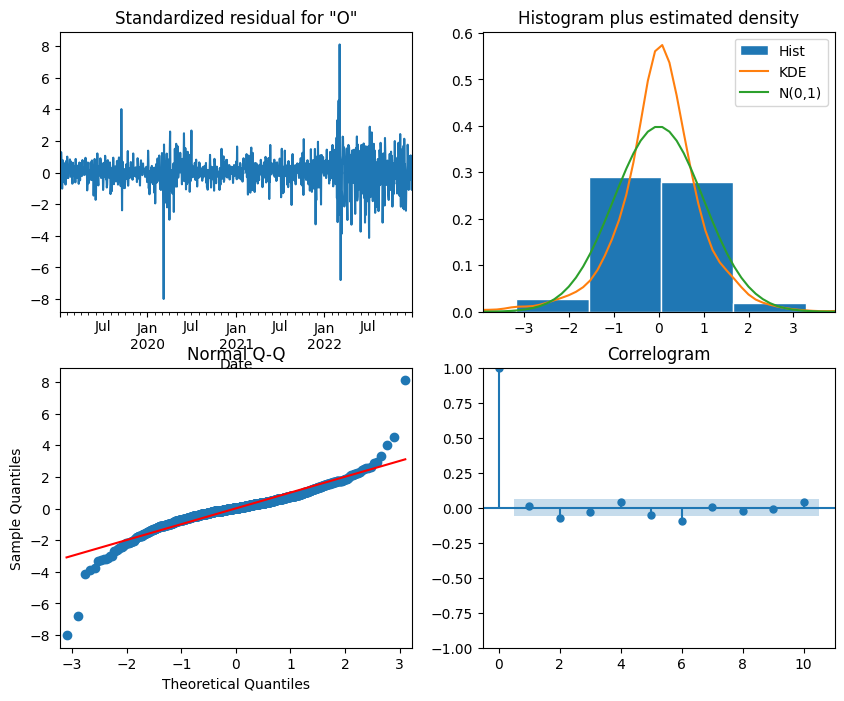

In [ ]:
oil_model_fit.plot_diagnostics(figsize=(10,8))
plt.show()


In [ ]:
# Get in-sample predictions
training_data_predictions = oil_model_fit.get_prediction(start=train_data_oil.dropna().index.min(),
                                                      end=train_data_oil.dropna().index.max(),
                                                      dynamic=False)

train_data_oil[['lower Oil predictions','Higher Oil predictions']] = training_data_predictions.conf_int()

# Create a new column for the predicted values
train_data_oil['Oil predictions'] = training_data_predictions.predicted_mean

train_data_oil

,Original_Oil_Price,lower Oil predictions,Higher Oil predictions,Oil predictions
Date,,,,
2019-01-02,52.14,-1959.966721,1959.966721,0.000000
2019-01-03,52.93,48.865015,55.415020,52.140017
2019-01-04,55.13,49.771705,56.275554,53.023629
2019-01-07,56.42,52.177396,58.668988,55.423192
2019-01-08,56.09,53.443444,59.933541,56.688492
...,...,...,...,...
2022-12-26,82.23,77.247193,83.658265,80.452729
2022-12-27,82.23,79.455459,85.866531,82.660995
2022-12-28,81.96,78.797827,85.208899,82.003363


In [ ]:
forecast = oil_model_fit.get_forecast(steps=5, alpha=0.05)
forecast.predicted_mean

2023-01-02    81.399469
2023-01-03    81.576954
2023-01-04    81.412067
2023-01-05    81.552095
2023-01-06    81.490670
Freq: B, Name: predicted_mean, dtype: float64

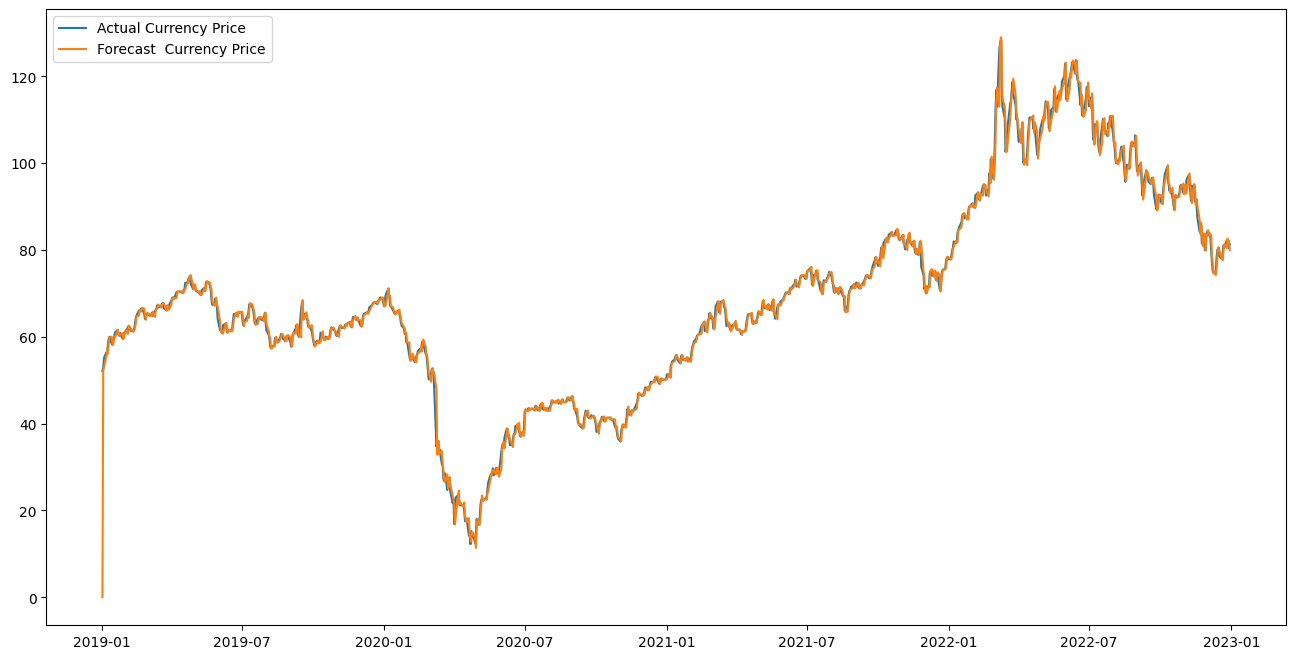

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(train_data_oil['Original_Oil_Price'],label="Actual Currency Price")
plt.plot(train_data_oil['Oil predictions'],label="Forecast  Currency Price")
plt.legend(loc="upper left")

In [ ]:
import pandas as pd

# define train test data
train = train_data_oil['Original_Oil_Price'].dropna()
test = test_data_oil['Original_Oil_Price'].dropna()

# define model configuration
my_order = (3,1,2)

# lists to collect forecasts
forecasts_oil = []
forecast_dates_oil = []

# walk-forward validation
history = [x for x in train]
for i in range(len(test)):
    if i % 5==0:
      #auto = auto_arima(history, error_action='ignore', suppress_warnings=True)
      #my_order = auto.order
      #print("my_order is {} for date {} is {}".format(my_order,test.index[i],forecast.predicted_mean[0]))
      model = ARIMA(history, order=my_order)
      model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=1, alpha=0.05)
    forecasts_oil.append(forecast.predicted_mean[0])
    forecast_dates_oil.append(test.index[i])
    history.append(forecast.predicted_mean[0])
    #print("Mean is {} for date {}".format(forecast.predicted_mean[0],test.index[i]))
    #print("Length of History is {} for date{} and order {} forecast is {}",format((len(history),test.index[i],my_order,forecast.predicted_mean[0])))
# Create a dataframe to hold the forecasts with corresponding dates
forecast__oil_df = pd.DataFrame(data={'Forecast': forecasts_oil}, index=forecast_dates_oil)



In [ ]:
forecast__oil_df.shape

(134, 1)

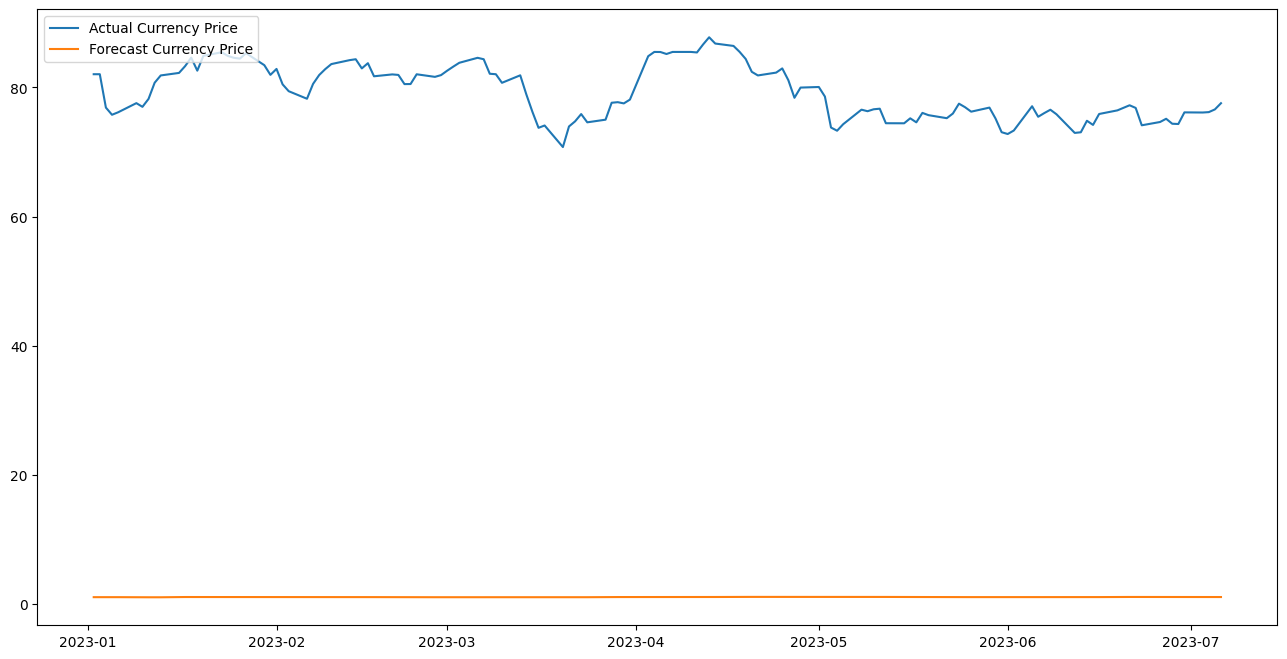

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(test_data_oil['Original_Oil_Price'],label="Actual Currency Price")
plt.plot(forecast_df['Forecast'],label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

cur_model=ARIMA(train_data_currency['Original_USD_EUR_Price'],order=(1,2,4),exog=train_data_oil['Original_Oil_Price'])
cur_model_fit=cur_model.fit()
cur_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:     Original_USD_EUR_Price   No. Observations:                 1043
Model:                     ARIMA(1, 2, 4)   Log Likelihood                4017.187
Date:                    Fri, 07 Jul 2023   AIC                          -8020.374
Time:                            15:36:43   BIC                          -7985.738
Sample:                        01-02-2019   HQIC                         -8007.236
                             - 12-30-2022                                         
Covariance Type:                      opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Original_Oil_Price -4.454e-05   5.56e-05     -0.802      0.423      -0.000    6.44e-05
ar.L1                 -0.7074      6.880     -0.103      0.918     -14.192      12.777
ma.L1                 -0.1269      6.878     -0.018      0.985     -13.608      13.355
ma.L2                 -0.6278      5.740     -0.109      0.913     -11.878      10.623
ma.L3                 -0.0812      0.249     -0.326      0.744      -0.569       0.407
ma.L4                 -0.0364      0.383     -0.095      0.924      -0.787       0.714
sigma2                2.6e-05   8.83e-07     29.466      0.000    2.43e-05    2.77e-05
===================================================================================
Ljung-Box (L1) (Q):                   4.09   Jarque-Bera (JB):               107.91
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               1.78   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

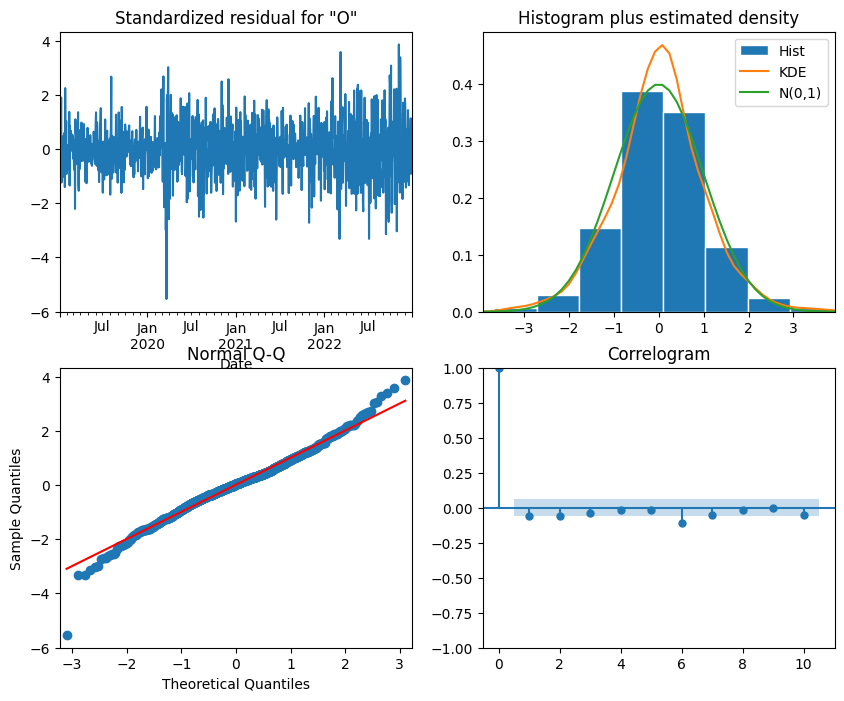

In [ ]:
cur_model_fit.plot_diagnostics(figsize=(10,8))
plt.show()


In [ ]:
# Get in-sample predictions
training_data_predictions = cur_model_fit.get_prediction(start=train_data_currency.dropna().index.min(),
                                                      end=train_data_currency.dropna().index.max(),
                                                      dynamic=False)

train_data_currency[['lower Cur predictions','Higher Oil predictions']] = training_data_predictions.conf_int()

# Create a new column for the predicted values
train_data_currency['Cur predictions'] = training_data_predictions.predicted_mean

train_data_currency

,Original_USD_EUR_Price,lower Cur predictions,Higher Oil predictions,Cur predictions
Date,,,,
2019-01-02,1.146171,-2771.809971,2771.805326,-0.002322
2019-01-03,1.131811,-1384.183442,1387.624207,1.720383
2019-01-04,1.139108,1.104354,1.130421,1.117387
2019-01-07,1.141044,1.124717,1.147711,1.136214
2019-01-08,1.147974,1.129205,1.151284,1.140244
...,...,...,...,...
2022-12-26,1.066780,1.051001,1.070991,1.060996
2022-12-27,1.064022,1.058705,1.078695,1.068700
2022-12-28,1.063717,1.055050,1.075039,1.065044


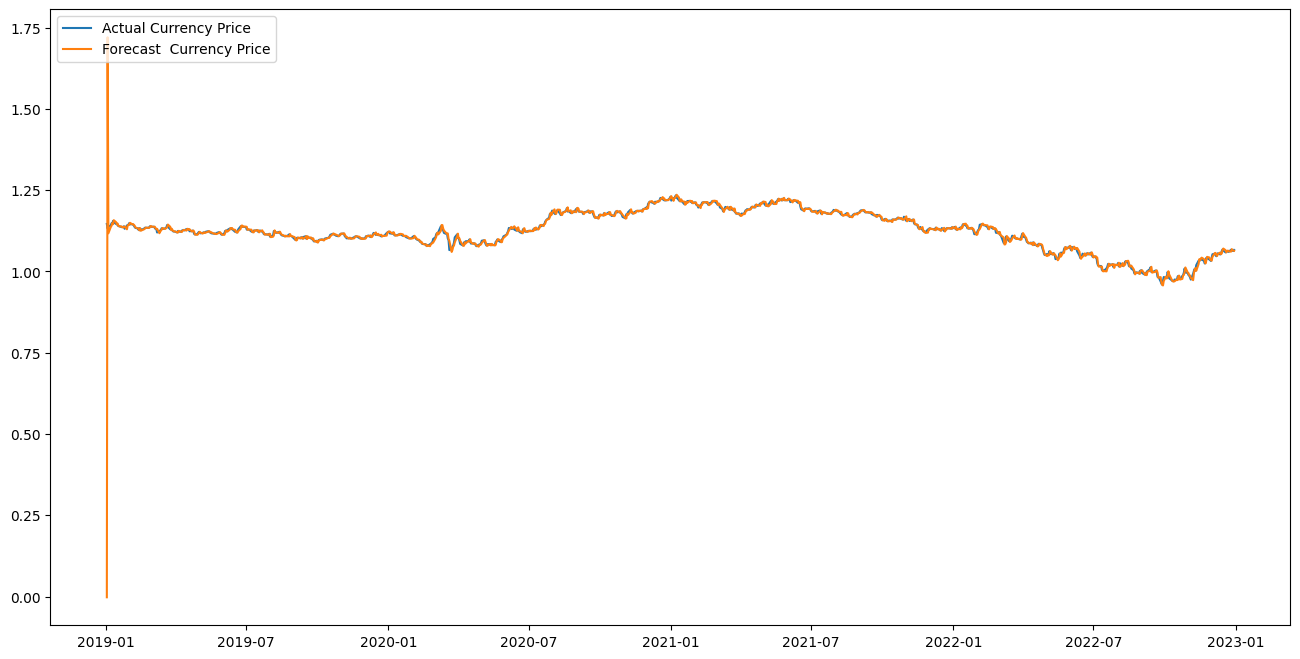

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(train_data_currency['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(train_data_currency['Cur predictions'],label="Forecast  Currency Price")
plt.legend(loc="upper left")

In [ ]:
# define train test data
train = train_data_currency['Original_USD_EUR_Price'].dropna()
test = test_data_currency['Original_USD_EUR_Price'].dropna()

forecast_oil=forecast__oil_df['Forecast']

# lists to collect forecasts
forecasts = []
forecast_dates = []

# walk-forward validation
history = [x for x in train]
exog_history = [x for x in train_data_oil['Original_Oil_Price']]

for i in range(len(test)):
    if i % 5==0:
      auto = auto_arima(history, error_action='ignore', suppress_warnings=True, d=2)
      my_order = auto.order
      print(f"Order is {my_order} for date {test.index[i]}, history length {len(history)}, exog length {len(exog_history)}")

      model = ARIMA(history, order=my_order, exog=np.array(exog_history).reshape(-1,1))
      model_fit = model.fit()

    # Make sure to reshape your exog data for the forecast
    exog_forecast = np.array([forecast_oil[i]]).reshape(-1,1)
    forecast = model_fit.get_forecast(steps=1, alpha=0.05, exog=exog_forecast)
    forecasts.append(forecast.predicted_mean[0])
    forecast_dates.append(test.index[i])
    history.append(test.iloc[i])
    exog_history.append(forecast_oil[i])

    print(f"Currency Price {forecast.predicted_mean[0]} & Oil Price {forecast_oil[i]} for date {test.index[i]} ")

# Create a dataframe to hold the forecasts with corresponding dates
forecast_df = pd.DataFrame(data={'Forecast': forecasts}, index=forecast_dates)

Order is (1, 2, 2) for date 2023-01-02 00:00:00, history length 1043, exog length 1043
Currency Price 1.0669813566810329 & Oil Price 81.39946946931262 for date 2023-01-02 00:00:00 
Currency Price 1.0669813566810329 & Oil Price 81.39946946931262 for date 2023-01-03 00:00:00 
Currency Price 1.0669813566810329 & Oil Price 81.39946946931262 for date 2023-01-04 00:00:00 
Currency Price 1.0669813566810329 & Oil Price 81.39946946931262 for date 2023-01-05 00:00:00 
Currency Price 1.0669813566810329 & Oil Price 81.39946946931262 for date 2023-01-06 00:00:00 
Order is (1, 2, 2) for date 2023-01-09 00:00:00, history length 1048, exog length 1048
Currency Price 1.0496786028349012 & Oil Price 81.3641905263065 for date 2023-01-09 00:00:00 
Currency Price 1.0496786028349012 & Oil Price 81.3641905263065 for date 2023-01-10 00:00:00 
Currency Price 1.0496786028349012 & Oil Price 81.3641905263065 for date 2023-01-11 00:00:00 
Currency Price 1.0496786028349012 & Oil Price 81.3641905263065 for date 2023-

In [ ]:
forecast_oil.tail(10)

2023-06-23    81.470120
2023-06-26    81.470871
2023-06-27    81.470871
2023-06-28    81.470871
2023-06-29    81.470871
2023-06-30    81.470871
2023-07-03    81.471440
2023-07-04    81.471440
2023-07-05    81.471440
2023-07-06    81.471440
Name: Forecast, dtype: float64

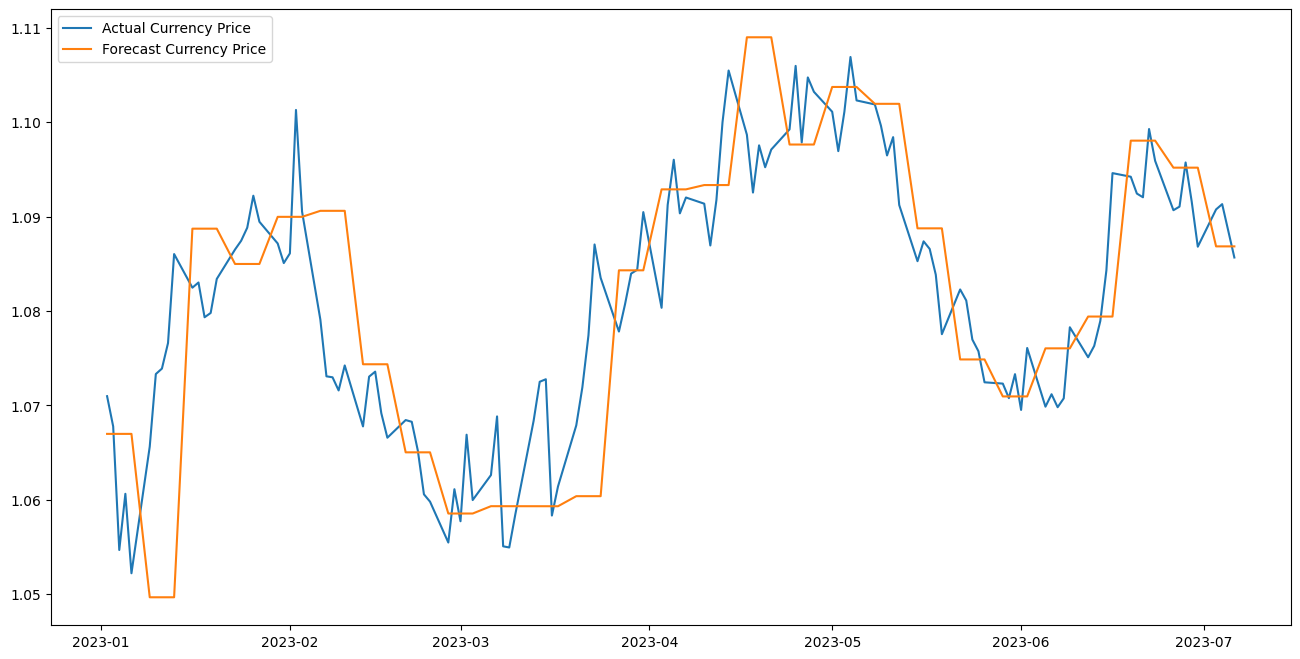

In [ ]:

plt.figure(figsize=(16,8))
plt.plot(test_data_currency['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(forecast_df['Forecast'],label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()
